# Locally Tilted Sampler — Training Flow Walkthrough

This notebook inspects the JAX/Flax NNX implementation: densities, flow network, and the segment flow matching trainer.

In [38]:
%load_ext autoreload
%autoreload 2

import jax
import jax.numpy as jnp
import numpy as np

import matplotlib.pyplot as plt

from locally_tilted_sampler import (
    FlowDimensions,
    GaussianDensity,
    TrainingConfig,
    make_gmm9,
    make_gmm40,
    plot_density,
    print_parameter_counts,
    train_locally_tilted_sampler,
)

jax.devices()[:1]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[CpuDevice(id=0)]

## 1) Densities
- `GaussianDensity`: exact log prob / sampling from a full-covariance Gaussian.
- `GaussianMixture` (`make_gmm9`, `make_gmm40`): mixture of isotropic components with stable log-sum-exp.
- `plot_density` helps visualize 2D targets on a grid.

In [39]:
prior = GaussianDensity.from_mean_cov([0.0, 0.0], [[1.5**2, 0.0], [0.0, 1.5**2]])
target = make_gmm9(scale=3.0, std=0.35)

# Evaluate log prob on a small batch
x_demo = jnp.array([[0.0, 0.0], [2.0, -1.0]])
prior_lp = prior.log_prob(x_demo)
target_lp = target.log_prob(x_demo)
prior_lp, target_lp

(Array([-2.6488073, -3.7599185], dtype=float32),
 Array([ 0.26176715, -7.9014883 ], dtype=float32))

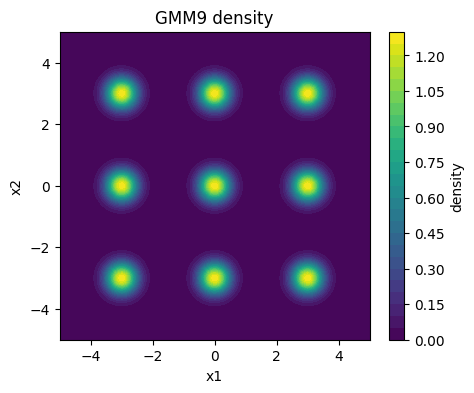

In [40]:
# Visualize the target density
fig, ax = plot_density(target.log_prob, bounds=(-5, 5), n_points=150)
ax.set_title("GMM9 density")
plt.show()

## 2) Flow model (Flax NNX)
The velocity field is a simple MLP conditioned on time via concatenation. All parameters live inside NNX modules and are mutated through the optimizer.

In [41]:
from locally_tilted_sampler.flow import FlowMLP
import flax.nnx as nnx

flow_dims = FlowDimensions(dim=2, hidden=128, depth=3)
rngs = nnx.Rngs(0)
flow = FlowMLP(flow_dims, rngs=rngs)

x = jnp.zeros((4, 2))
t = jnp.zeros((4, 1))
v = flow(x, t)
v.shape

(4, 2)

In [42]:
print_parameter_counts(flow, module_name="FlowMLP", max_depth=3)

Parameter Count Analysis: FlowMLP

FlowMLP            50,306 params    100.0%  [██████████████████████████████]
├── hidden         49,536 params     98.5%  [█████████████████████████████░]
├── input             512 params      1.0%  [░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░]
└── output            258 params      0.5%  [░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░]

────────────────────────────────────────────────────────────────────────────────
TOTAL              50,306 params  100.0%

Summary Statistics (depth=1 modules):
  - Number of modules: 3
  - Largest module: 49,536 params
  - Smallest module: 258 params
  - Average module: 16,768 params



## 3) Loss: segment flow matching
Sampling pairs `(x_ts, x_te)` from importance resampling, draw random `t`, and regress the velocity toward the segment displacement.

In [43]:
from locally_tilted_sampler.segment_flow_matching import compute_weighted_loss

key = jax.random.PRNGKey(1)
x_ts = target.sample(key, (16,))
x_te = x_ts + 0.1 * jax.random.normal(key, x_ts.shape)
loss = compute_weighted_loss(flow, key, x_ts, x_te)
loss

Array(0.4210431, dtype=float32)

## 4) Training loop
Uses `nnx.Optimizer` + Optax AdamW. Each time slice trains its own flow, then propagates samples through that flow to become the next slice's starting point.

In [44]:
mini_config = TrainingConfig(
    time_slices=4,
    solver_substeps=16,
    lr=1e-3,
    max_updates=4000,
    train_samples=10240,
    train_batch_size=256,
    seed=42,
    use_ancestral_pairs=False,
)

train_result = train_locally_tilted_sampler(
    flow_dims=FlowDimensions(dim=2, hidden=128, depth=3),
    prior=prior,
    target=target,
    config=mini_config,
)
train_result.loss_log

Parameter Count Analysis: Flow

Flow               50,306 params    100.0%  [██████████████████████████████]
├── hidden         49,536 params     98.5%  [█████████████████████████████░]
├── input             512 params      1.0%  [░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░]
└── output            258 params      0.5%  [░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░]

────────────────────────────────────────────────────────────────────────────────
TOTAL              50,306 params  100.0%

Summary Statistics (depth=1 modules):
  - Number of modules: 3
  - Largest module: 49,536 params
  - Smallest module: 258 params
  - Average module: 16,768 params

[time slice start] t=0.0000, delta_t=0.2500, samples=10240
  step 0000  loss=9.924425
  step 0050  loss=9.978880
  step 0100  loss=10.226159
  step 0150  loss=10.255965
  step 0200  loss=9.153760
  step 0250  loss=9.786564
  step 0300  loss=10.522983
  step 0350  loss=9.755007
  step 0400  loss=10.412479
  step 0450  loss=11.796168
  step 0500  loss=9.557272
  step 0550

[6.838225841522217, 7.289839744567871, 8.259174346923828, 8.972610473632812]

## 5) Propagated samples snapshot
Plot the final sample distribution against the target density to inspect mode coverage.

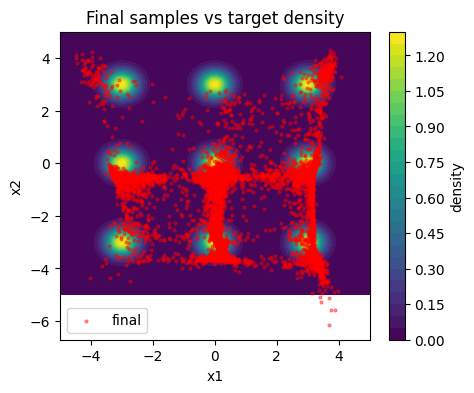

In [45]:
final_samples = jnp.array(train_result.final_samples)
fig, ax = plot_density(target.log_prob, bounds=(-5, 5), n_points=150)
ax.scatter(final_samples[:, 0], final_samples[:, 1], s=4, c="r", alpha=0.4, label="final")
ax.legend()
ax.set_title("Final samples vs target density")
plt.show()